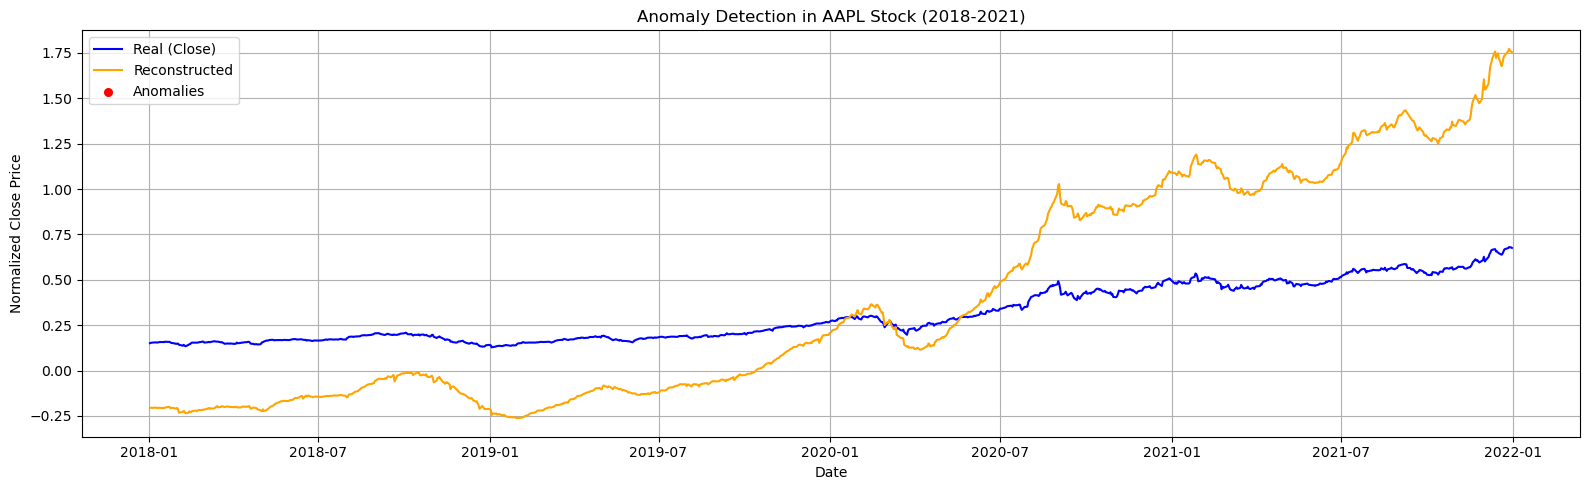

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from transformers import TransformerAutoencoder  # Make sure this matches your actual model file
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize(data):
    mean = data.mean(axis=(0, 1), keepdims=True)
    std = data.std(axis=(0, 1), keepdims=True)
    return (data - mean) / (std + 1e-8)

def load_data(seq_file, original_csv):
    data = pd.read_csv(seq_file).values.reshape(-1, 30, 5).astype(np.float32)
    norm_data = normalize(data)
    tensor_data = torch.tensor(norm_data)
    dataset = TensorDataset(tensor_data)
    loader = DataLoader(dataset, batch_size=64)

    original_df = pd.read_csv(original_csv)
    dates = pd.to_datetime(original_df["Date"], utc=True)
    aligned_dates = dates[29:29 + len(data)]  # Align with last timestep of each window
    return loader, data, aligned_dates

def reconstruct(model, loader):
    model.eval()
    reconstructions = []
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            out = model(x).cpu()
            reconstructions.append(out)
    return torch.cat(reconstructions, dim=0).numpy()

def plot_reconstruction(dates, real_close, reconstructed_close, anomalies, company, start_year=2018, end_year=2021):
    mask = (dates.dt.year >= start_year) & (dates.dt.year <= end_year)
    plt.figure(figsize=(16, 5))
    plt.plot(dates[mask], real_close[mask], label="Real (Close)", color='blue')
    plt.plot(dates[mask], reconstructed_close[mask], label="Reconstructed", color='orange')
    plt.scatter(dates[mask][anomalies[mask]], real_close[mask][anomalies[mask]], color='red', label="Anomalies", s=30)
    plt.title(f"Anomaly Detection in {company} Stock ({start_year}-{end_year})")
    plt.xlabel("Date")
    plt.ylabel("Normalized Close Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def main():
    company = "AAPL"
    model_path = Path(f"../../models/transformers/{company.lower()}_transformer_autoencoder.pth")
    seq_file = f"../../data/sequences_ready/{company}_data_sequences.csv"
    original_csv = f"../../data/processed_data/{company}_data.csv"

    # Load and prepare
    loader, original_data, dates = load_data(seq_file, original_csv)
    model = TransformerAutoencoder(input_dim=5, seq_len=30).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Reconstruct
    reconstructed = reconstruct(model, loader)

    # Use close price (last feature)
    real_close = original_data[:, -1, 3]  # feature index 3 = Close
    reconstructed_close = reconstructed[:, -1, 3]
    reconstruction_error = (real_close - reconstructed_close) ** 2
    threshold = np.percentile(reconstruction_error, 95)
    anomalies = reconstruction_error > threshold

    # Plot
    plot_reconstruction(dates, real_close, reconstructed_close, anomalies, company)

if __name__ == "__main__":
    main()
